# Feature Extraction (Deep Learning Features)

## Part 2

**Author**: Maleakhi Agung Wijaya  
**Email**: maw219@cam.ac.uk  
**Description**: This file contains code for extracting deep learning features. We considered using autoencoders and pre-trained neural networks with random weights as feature extractors. See part 1, where we experimented with VGG16, VGG19, InceptionV3, and ResNet50 using ImageNet weights. See part 3 where we experiment using data augmentation and fine tuning the pretrained network.

In [42]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px
import plotly.graph_objects as go
import scipy.io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
import pickle
from scipy.spatial.distance import cdist
from sklearn.decomposition import IncrementalPCA, TruncatedSVD
from sklearn.random_projection import SparseRandomProjection

# Images
import os
import cv2
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.style as style
from skimage.io import imread, imshow
import re

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras import optimizers
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, backend as K, callbacks, losses
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [62]:
%run Utilities.ipynb

## Load and Preprocess Dataset

This section loads shell images one-by-one and concatenate the forward and rear image.

In [3]:
filenames = sorted(os.listdir(SHELL_IMAGES_DATA))
X_species, y_species = preprocess_x_y(filenames)
le = LabelEncoder()
y_species = le.fit_transform(y_species)

1


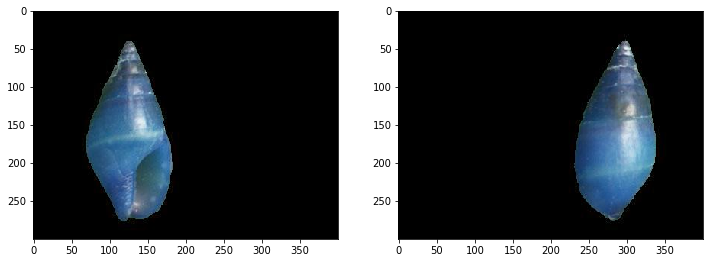

In [4]:
# Test visualise image
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print(y_species[12])
image1 = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_species[32][0]))
image2 = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_species[32][1]))
ax1.imshow(image1)
ax2.imshow(image2)

plt.show()

## Random Weights

Jarrett et al. (2009) reported that the combination of random convolutional fitlers, rectification, pooling, and local normalization can work almost as well as learned features. For the reason, we use InceptionNet with random weight to compare the performance against part 1, where we used ImageNet weights.

In [5]:
model = InceptionV3(weights=None, include_top=False, pooling="avg", input_shape=(299, 299, 3))

In [6]:
# Set non trainable in our case
for layer in model.layers:
    layer.trainable=False

In [7]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
# Store features
X_features_inception_a = []
X_features_inception_b = []

In [9]:
### This cells only for extracting A (cannot do both at the same time,
# memory issue)
for X in tqdm(X_species):
    X_a = X[0] # A position
    X_b = X[1] # B position
    
    # Open the image in gray scale
    image_a = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_a), cv2.IMREAD_COLOR)
    image_b = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_b), cv2.IMREAD_COLOR)
    
    # Preprocess the image
    image_a = cv2.resize(image_a, (299, 299))
    image_b = cv2.resize(image_b, (299, 299))
    
    image_a = cv2.cvtColor(image_a, cv2.COLOR_RGB2BGR)
    image_a = image_a / 255.0
    image_a = np.reshape(image_a, (-1, 299, 299, 3))
    
    image_b = cv2.cvtColor(image_b, cv2.COLOR_RGB2BGR)
    image_b = image_b / 255.0
    image_b = np.reshape(image_b, (-1, 299, 299, 3))
    
    # Block 1 - fc
    X_features_inception_a.append(model.predict(image_a))
    X_features_inception_b.append(model.predict(image_b))

In [10]:
## Save objects
save_object(X_features_inception_a, "../results/random_a.pickle")
save_object(X_features_inception_b, "../results/random_b.pickle")

### Further Preprocessing

We further preprocessing the extracted features for later to be used for classification. We used dimensionality reduction method, like PCA.

In [18]:
X_inception_a = load_object("../results/random_a.pickle")
X_inception_b = load_object("../results/random_b.pickle")

# Reshape 
X_inception_a = np.reshape(X_inception_a, (1340, -1))
X_inception_b = np.reshape(X_inception_b, (1340, -1))

# Dimensionality reduction using PCA as we have too many
# features at the moment.
pca = PCA(n_components=.9)
X_inception_a = pca.fit_transform(X_inception_a)
X_inception_b = pca.fit_transform(X_inception_b)

print(X_inception_a.shape)
print(X_inception_b.shape)

X_inception = np.concatenate((X_inception_a, X_inception_b), axis=1)
save_object(X_inception, "../results/X_random.pickle")

(1340, 13)
(1340, 14)


In [19]:
# Load
X_random = load_object("../results/X_random.pickle")
scaler = StandardScaler()
X_random_scaled = scaler.fit_transform(X_random)

## Classification

#### Standard ML Models

In [20]:
## Hyperparameter configurations and result storage
param_grid_svc = {
    # random search varying the parameter
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': ["scale", "auto"], 
    'kernel': ["rbf", "linear"]
}

param_grid_rf = { 
    'n_estimators': [10, 100, 200],
    'criterion' :['gini', 'entropy']
}

# Used to store results for different feature sets
list_dict_results = []

In [21]:
## Loop configuration
feature_sets = [
    (X_random, y_species),
    (X_random_scaled, y_species),
]
feature_sets_name = [
    "Inception",
    "Inception scaled",
]

## Classifier and hyperparameter loops
param_grids = [param_grid_svc, param_grid_rf]
classifiers_name = ["svc", "rf"]
classifiers = [SVC(), RandomForestClassifier()]
cmaps = ["plasma", "viridis"]

**************************************************
Inception
------------------------------
svc
Accuracy: 0.691044776119403
F1: 0.6674543946932007


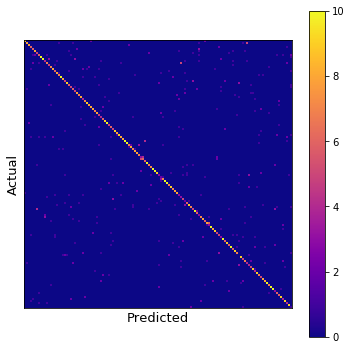


------------------------------
rf
Accuracy: 0.8261194029850746
F1: 0.8078678038379531


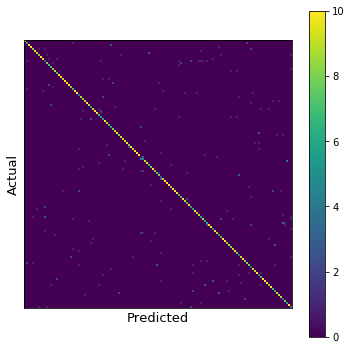


**************************************************
Inception scaled
------------------------------
svc
Accuracy: 0.8597014925373134
F1: 0.8453518123667377


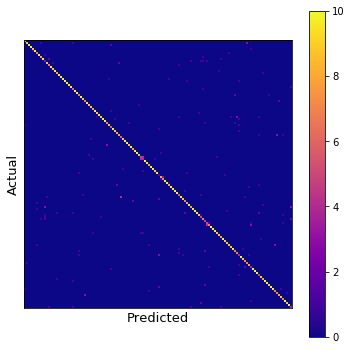


------------------------------
rf
Accuracy: 0.8395522388059702
F1: 0.825105425254679


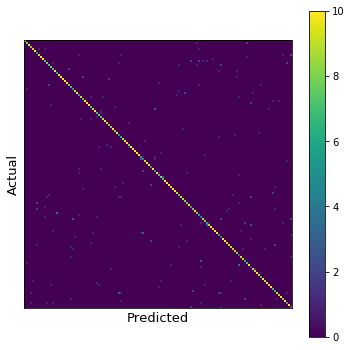

In [22]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    # Iterate over different classifiers
    for classifier, classifier_name, param_grid, cmap in zip(classifiers, 
                                                             classifiers_name, 
                                                             param_grids,
                                                             cmaps):
        print("-"*30)
        print(classifier_name)

        list_acc, list_cm, list_f1, list_cv_results = nested_cv_sklearn(classifier, param_grid, X, y, 5)
        # Add data to dict_results
        dict_results["accuracy"].append(list_acc)
        dict_results["f1"].append(list_f1)
        dict_results["cv_results"].append(list_cv_results)
        dict_results["cm"].append(list_cm)

        # Display accuracy, f1, confusion matrix
        print(f"Accuracy: {np.mean(list_acc)}")
        print(f"F1: {np.mean(list_f1)}")
        cm = sum(list_cm)

        plot_confusion_matrix(cm, cmap=cmap)

        print()
    
    list_dict_results.append(dict_results)

#### Neural Networks

In [26]:
## Loop configuration
feature_sets = [
#     (X_random, y_species),
    (X_random_scaled, y_species),
]
feature_sets_name = [
#     "Inception",
    "Inception scaled",
]


In [27]:
# Neural network configuration (simple one for standard)
# see more complex version on utilities.ipynb that are evaluated
# on other files.
optimizer = keras.optimizers.Adam()
batch_size = 64
no_epochs = 200

**************************************************
Inception scaled
Accuracy: 0.8402985074626865
F1: 0.8054773750296139


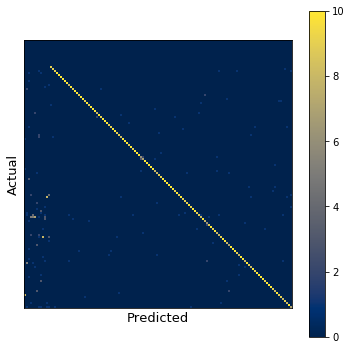

In [28]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    
    # Neural network training
    X = np.array(X)
    y = np.array(y)
    
    # Simple model definition
    model = keras.Sequential(
        [
            layers.Dense(64, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(255, activation="relu"),
            layers.Dense(134, activation="softmax"),
        ]
    )
    
    for train, test in kfold.split(X, y):
        model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=optimizer,
                     metrics=["accuracy"])
        
        # Valid data
        valid_range = int(0.1 * len(train))
        valid = train[:valid_range]
        train = train[valid_range:]
        
        # Early stopping callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0, patience=20,
            mode="auto", restore_best_weights=False
        )
        
        # Fit data to model
        history = model.fit(X[train], y[train],
                  batch_size=batch_size,
                  epochs=no_epochs, verbose=0, 
                  validation_data=(X[valid], y[valid]),
                  callbacks=[early_stopping])
        
        # Generate generalisation metrics
        pred = model.predict(X[test])
        pred = np.argmax(pred, axis=1)
        cm = confusion_matrix(pred, y[test])
        acc = accuracy_score(pred, y[test])
        f1 = f1_score(pred, y[test], average="macro")
        
        # Add data to dict results
        dict_results["accuracy"].append(acc)
        dict_results["f1"].append(f1)
        dict_results["cm"].append(cm)
        
    # Display accuracy, f1, confusion matrix
    print(f"Accuracy: {np.mean(dict_results['accuracy'])}")
    print(f"F1: {np.mean(dict_results['f1'])}")
    plot_confusion_matrix(sum(dict_results['cm']), cmap="cividis")

    print()

    list_dict_results.append(dict_results)

## Autoencoders

We build autoencoder and extract features from the encoder network.

### Loading Datasets
Note that as we trained autoencoders from scratch, it is becoming necessary to load the data using the tf.data pipeline.

In [63]:
datagen = ImageDataGenerator(
    rescale=1./255, # normalise the images
    validation_split=0.1,
    dtype=tf.float32
)

# Training and validation for autoencoders
train_generator = datagen.flow_from_directory(
    "../data/shell_species/",
    target_size=(224, 224),
    batch_size=64,
    class_mode="input",
    seed=123,
    subset="training",
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    "../data/shell_species/",
    target_size=(224, 224),
    batch_size=64,
    class_mode="input",
    seed=123,
    subset="validation",
    shuffle=True
)

Found 2412 images belonging to 1 classes.
Found 268 images belonging to 1 classes.


In [ ]:
encoder, autoenc = autoencoder(train_generator, 
                               validation_generator)

Epoch 1/10
38/38 [==============================] - 51s 1s/step - loss: 0.1939 - val_loss: 0.1599
Epoch 2/10
38/38 [==============================] - 50s 1s/step - loss: 0.1286 - val_loss: 0.0943
Epoch 3/10
38/38 [==============================] - 50s 1s/step - loss: 0.0764 - val_loss: 0.0635
Epoch 4/10
38/38 [==============================] - 52s 1s/step - loss: 0.0600 - val_loss: 0.0579
Epoch 5/10
38/38 [==============================] - 52s 1s/step - loss: 0.0570 - val_loss: 0.0568
Epoch 6/10
38/38 [==============================] - 50s 1s/step - loss: 0.0563 - val_loss: 0.0565
Epoch 7/10
38/38 [==============================] - 52s 1s/step - loss: 0.0559 - val_loss: 0.0562
Epoch 8/10
38/38 [==============================] - 52s 1s/step - loss: 0.0555 - val_loss: 0.0556
Epoch 9/10
38/38 [==============================] - 51s 1s/step - loss: 0.0529 - val_loss: 0.0475
Epoch 10/10
38/38 [==============================] - ETA: 0s - loss: 0.0294

### Verify Autoencoders

We will verify how well the trained autoencoders reconstruct the shell images.

In [54]:
filenames = sorted(os.listdir(SHELL_IMAGES_DATA))
X_species, y_species = preprocess_x_y(filenames)
le = LabelEncoder()
y_species = le.fit_transform(y_species)

In [55]:
# Set images to be reconstructed
x_test_path = os.listdir(SHELL_IMAGES_DATA)[:30]
x_test = []
for path in x_test_path:
    image = cv2.imread(os.path.join(SHELL_IMAGES_DATA, path))
    image = image / 255.0
    x_test.append(image)

In [59]:
x_test = np.array(x_test)

(30, 300, 400, 1)


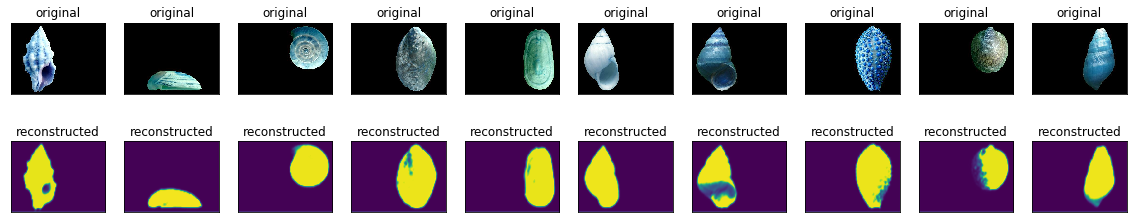

In [61]:
# Evaluate whether autoencoder works as intended
n = 10
plt.figure(figsize=(20, 4))
decoded_imgs = autoenc(x_test).numpy()
print(decoded_imgs.shape)

for i in range(n):
    # Display original image
    ax = plt.subplot(2, n, i+1)
    plt.imshow(np.squeeze(x_test[i]))
    plt.title("original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(np.squeeze(decoded_imgs[i]))
    plt.title("reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()